# Portfolio Construction

Warning upfront: expected returns estimates -> error in parameter estimates -> lack of robustness in Markowitz Analysis where optimizers act as error maximizing machines -> Improving parameter estimates -> see Global Minimum Variance Portfolio and Equally-Weighted Portfolio

In [1]:
import numpy as np # to use arrays instead of lists
import pandas as pd # using values, shift, and pct_change

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# warnings and ignore for ease of reading notebook
import warnings
warnings.filterwarnings("ignore")

# quadratic optimizer
import scipy.stats as st
from scipy.optimize import minimize

# load autoreload extension
%load_ext autoreload 
# set to mode 2 
%autoreload 2 
# import created module
import edhec_risk_kit as erk

### Efficient Frontier

about the data: starting in 1926 up to 2018, monthly returns of 30 different industry portfolios, 30 columns corresponding to the industries, 1 column YYYYMM, returns are represented as a %

Load and Clean Data

In [2]:
# import data
path = r'C:\Users\breta\OneDrive\Desktop\Workspace\EDHEC\ind30_m_vw_rets.csv'
# set date column as index, header in row 0, convert from %
ind = pd.read_csv(path, header=0, index_col=0)/100
# date is as if int, parse does not work, convert to datetime YYYY-MM-01 --> to period M --> YYYY-MM
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [3]:
# look at columns
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

In [4]:
# clean whitespace, prevent indexing issues ['Food ']
ind.columns = ind.columns.str.strip()
ind.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

In [5]:
# number rows and columns
ind.shape

(1110, 30)

define `get_ind_returns()` in erk module

In [80]:
# check defined function
ind = erk.get_ind_returns()
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


Portfolio Characteristics

<Axes: >

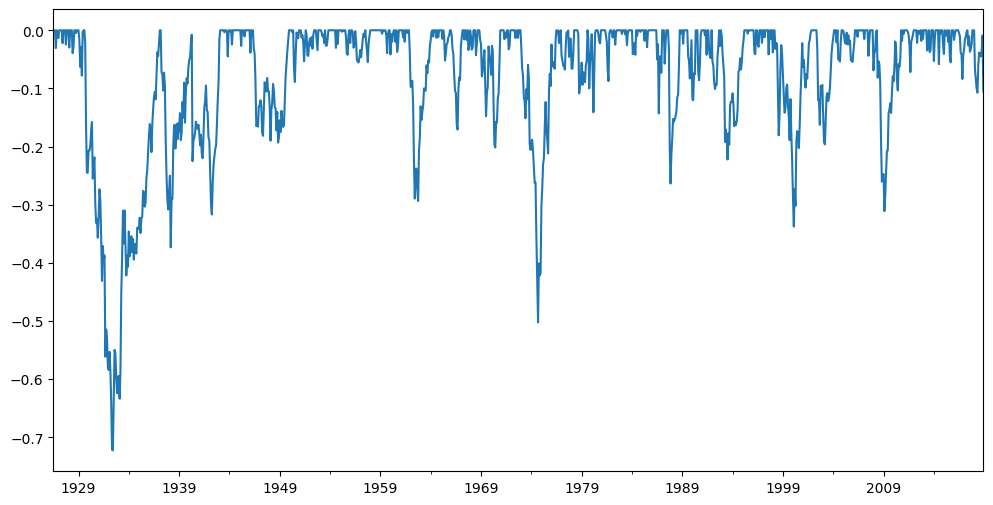

In [81]:
# compute drawdowns for Food portfolio
erk.drawdown(ind.Food)['Drawdown'].plot(figsize=[12,6])

In [82]:
# compute one VaR measure for several portfolios
erk.var_cornish_fisher(ind[['Food', 'Smoke', 'Coal', 'Beer', 'Fin']])

Food     0.061207
Smoke    0.080292
Coal     0.047359
Beer     0.033881
Fin      0.075199
dtype: float64

In [83]:
# compute for all, look at highest value at risk
erk.var_cornish_fisher(ind).sort_values().tail()

Carry    0.094527
Meals    0.098403
BusEq    0.099377
Games    0.100701
Mines    0.102782
dtype: float64

In [84]:
# compute for all, look at least value at risk
erk.var_cornish_fisher(ind).sort_values().head()

Beer     0.033881
Coal     0.047359
Food     0.061207
Telcm    0.064719
Hshld    0.064886
dtype: float64

<Axes: >

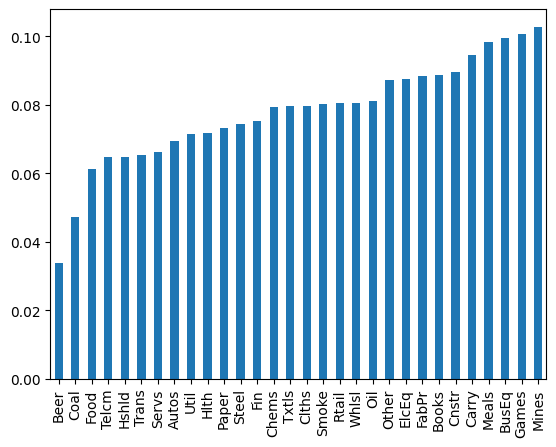

In [85]:
erk.var_cornish_fisher(ind).sort_values().plot(kind='bar')

Compute Initial Statistics

define `annualize_rets`, `annualize_vol` and `sharpe_ratio` in erk module

3.72


<Axes: title={'center': 'Industry Sharpe Ratios 1926-2018'}>

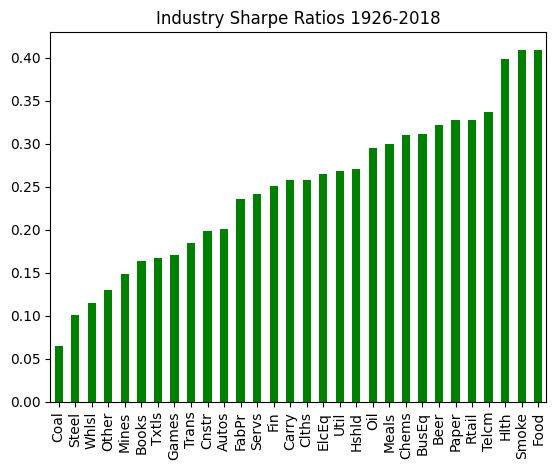

In [86]:
# calculate sharpe ratios, assess risk-adjusted performance
erk.sharpe_ratio(ind, periods_per_year=12).sort_values().plot(kind='bar', 
                                                              title='Industry Sharpe Ratios 1926-2018', 
                                                              color='green')

coal has a mediocre sharpe ratio over the time period; food, smoke, healthcare are the sectors that have provided outstanding sharpe ratios over this period of time

3.72


<Axes: title={'center': 'Industry Sharpe Ratios 2000-2018'}>

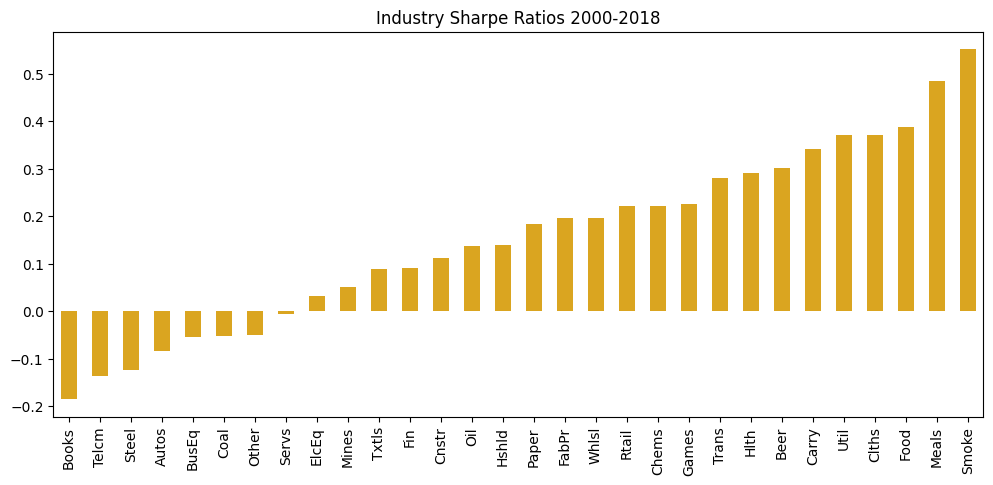

In [87]:
# look at 2000 onwards
erk.sharpe_ratio(ind['2000':], periods_per_year=12).sort_values().plot(kind='bar', 
                                                              figsize=(12,5),
                                                              title='Industry Sharpe Ratios 2000-2018', 
                                                              color='goldenrod')

now we see some poor performance, the portfolio has returned less than the risk-free rate with books, telcom, steel and autos especially; meals and smoking performed very well from 2000 to 2018

Efficient Frontier
* compute expected returns
    - over the next period of investment for forecasting
    - as a historical analysis of efficient frontier, simply using insample returns
* correlations
* volatilities
* embed correlations and volatilities in covariance matrix `.cov`
* generate the efficient frontier
    - forecasting desired
    - here historical analysis

<Axes: >

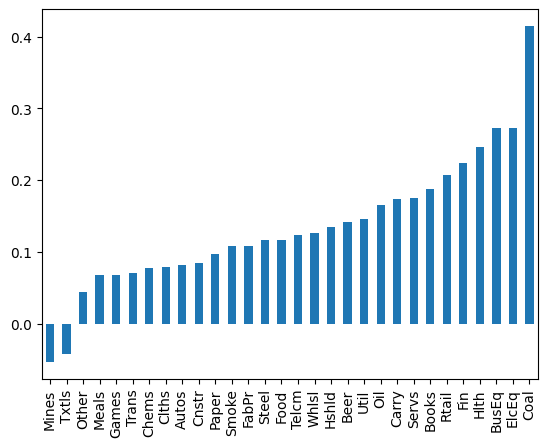

In [88]:
# expected returns (historical for insample), calculate returns 1996-2000
# looking at eff. front. historical
er = erk.annualize_rets(ind['1996':'2000'], 12)
er.sort_values().plot(kind='bar')

<Axes: >

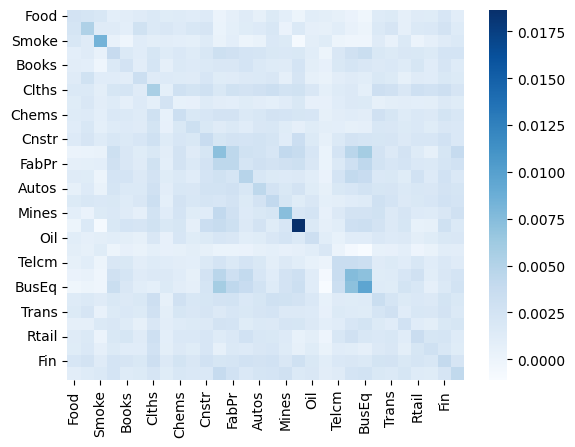

In [90]:
# calculate covariance matrix for returns from 1996 to 2000
cov = ind['1996':'2000'].cov()
sns.heatmap(cov, cmap='Blues')

Generate Portfolios and Plot
* portfolio: allocation of capital
* weights: determine how much is put into each asset

For every possible portfolio, every possible allocation of weights, position on risk/return map

In [91]:
# WEIGHTS --> WEIGHTED RETURN:
# Rp = WTR
# where WT is the transpose of the Weight Vector
# weight vector (k*1) k by one vector, 
# where k is the number of assets. 
## So if you take the transpose of the weight matrix and you multiply it by the return vector, 
## which is again the k by its column vector of the returns of those assets --> weighted return, weighted average return. 
def portfolio_return(weights, returns): 
    return weights.T @ returns

In [92]:
# WEIGHTS --> VOLATILITY/VARIANCE
# volatility/variance sigma = sqrt(WT sum W)
def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

In [93]:
# scenario assets, portfolios
l = ["Food", "Beer", "Smoke", "Coal"]
# 'expected' return vector of assets, 'expected return' er = erk.annualize_rets(ind['1996':'2000'], 12)
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [94]:
# covariance matrix of assets
# cov = ind['1996':'2000'].cov(), index by row and column index l
cov.loc[l,l] # just subset of covariance matrix of all portfolios

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [95]:
# weights
# array with 1/4th in each asset, for 4 assets
weights = np.repeat(1/4, 4) 
weights

array([0.25, 0.25, 0.25, 0.25])

In [96]:
# weighted return

erk.portfolio_return(weights=weights, returns=er[l]) # 19.5% return

0.19511097196038385

In [97]:
# volatility

erk.portfolio_vol(weights=weights, covmat=cov.loc[l,l])

0.055059195776437045

Two Asset Frontier
* generate a set of dots and connect them all
* dot = a portfolio 

In [26]:
# pick assets
l = ['Games', 'Fin']

In [27]:
# list of weights, weight vector
# start: 100% in games
# end: 100% in finance
# between: n possible between start and end

# n number of points/portfolios
n_points = 20
# iterable for finding w weight pairs
np.linspace(0, 1, n_points) # 20 points equally spaced from 0 to 1

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [28]:
# list of weight vectors, list of arrays
# 2 weights for 2 assets
# where weights are related by 1-w
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights # 20 points

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [29]:
# find return and volatility corresponding to each pair of weights

# again assets
l

['Games', 'Fin']

In [30]:
# list of returns
rets =[erk.portfolio_return(w, er[l]) for w in weights]
rets

[0.22337143343356036,
 0.21520512368930153,
 0.20703881394504264,
 0.19887250420078378,
 0.19070619445652492,
 0.18253988471226607,
 0.17437357496800718,
 0.16620726522374832,
 0.15804095547948946,
 0.14987464573523063,
 0.14170833599097174,
 0.13354202624671288,
 0.12537571650245402,
 0.11720940675819516,
 0.1090430970139363,
 0.10087678726967743,
 0.09271047752541857,
 0.08454416778115972,
 0.07637785803690085,
 0.06821154829264198]

In [31]:
# list of volatilities
vols = [erk.portfolio_vol(w, cov.loc[l,l]) for w in weights]
vols

[0.0630997295785121,
 0.06184548206317772,
 0.06069878923524834,
 0.05966585256137839,
 0.058752672223312284,
 0.05796490842860514,
 0.05730773341483651,
 0.05678568123574939,
 0.056402504039475894,
 0.0561610444586889,
 0.05606313362372235,
 0.05610952301512326,
 0.056299855936855894,
 0.05663268109748638,
 0.05710550711027121,
 0.05771489323047962,
 0.05845656886221488,
 0.05932557264732352,
 0.06031640142594411,
 0.061423159933946626]

In [32]:
# create a dataframe for convenience
ef = pd.DataFrame({'R': rets,
                   'Vol': vols})
ef

,R,Vol
0,0.223371,0.063100
1,0.215205,0.061845
2,0.207039,0.060699
3,0.198873,0.059666
4,0.190706,0.058753
5,0.182540,0.057965
6,0.174374,0.057308
7,0.166207,0.056786
8,0.158041,0.056403
9,0.149875,0.056161


<Axes: xlabel='Vol', ylabel='R'>

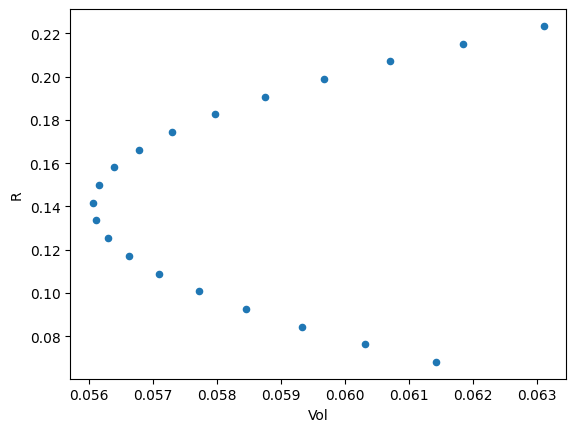

In [33]:
# plot
ef.plot(kind='scatter', x='Vol', y='R')

<Axes: xlabel='Volatility'>

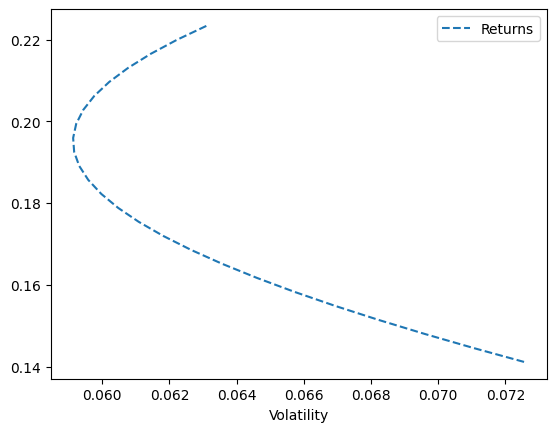

In [36]:
# use erk function

# assets
l = ['Fin', 'Beer']
# expected returns
ers = er[l]
# covariance matrix
covm = cov.loc[l,l]
# n points/portfolios
n = 25

erk.plot_ef2(n_points=n, er=ers, cov=covm, style='--') 

# N-Asset Efficient Frontier

Applying Quadprog to Draw the Efficient Frontier

In [2]:
# load industry portfolio data and format
ind = erk.get_ind_returns()

In [3]:
# generate 'expected returns' 1996 to 2000
er = erk.annualize_rets(ind["1996":"2000"], 12)

In [4]:
# generate covariance matrix 1996 to 2000
cov = ind["1996":"2000"].cov()

### Minimize Volatility for a Target Return

Review the 2 asset construction

In [98]:
# define a few assets within industry portfolios
l = ['Games', 'Fin']

<Axes: xlabel='Volatility'>

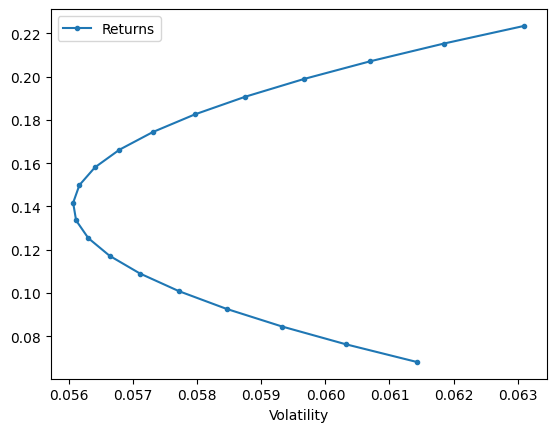

In [99]:
# plot efficient frontier for l assets
erk.plot_ef2(n_points=20, er=er[l], cov=cov.loc[l,l])

In [100]:
er[l]

Games    0.068212
Fin      0.223371
dtype: float64

Gameplan for N-Assets
* lowest possible return: 0.068212
* highest possible return: 0.223371
* formulate a method to find the volatility from any given vector along the curve of all possible return allocations
* pick a return on the curve between 0.15, 15%
* volatiliy at a return of 15% ? ...
* obtaining the weight of allocation in the N portfolios ? ...

In [101]:
l

['Games', 'Fin']

In [102]:
# minimize volatility for target return, see erk

# utilize the optimizer for 15% return target
w15 = erk.minimize_vol(target_return=0.15, er=er[l], cov=cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [103]:
w15

array([0.47287631, 0.52712369])

with a target return of 15%, if you allocate 47.3% in games and 52.7% in finance, then you will acheive the lowest possible volatility of 5.62%, see above curve that matches this optimization

### Four Assets A

In [22]:
l = ['Smoke', 'Fin', 'Games', 'Coal']

<Axes: xlabel='Volatility'>

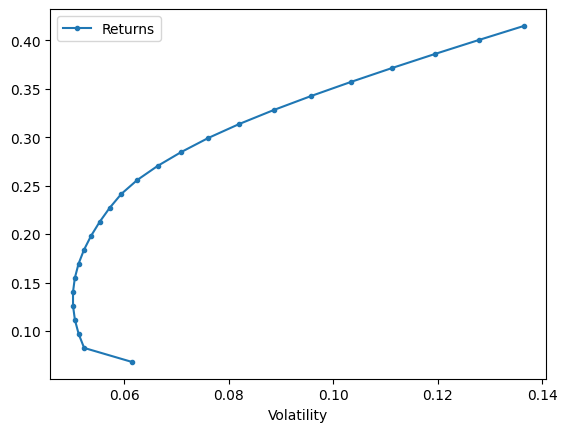

In [23]:
# plot N-asset efficient frontier for l assets
erk.plot_ef(n_points=25, er=er[l], cov=cov.loc[l,l])

# Locating the Max Sharpe Ratio Portfolio (MSR)

warning: MSR portfolio based on sample estimates is highly subject to estimation errors, and will likely have poor out-of-sample Sharpe Ratio
* Global minimum variance portfolio (GMV) is least sensitive to estimation errors, as it does not require return estimates, it is only sensitive to errors in risk parameter estimates

maximum possible Sharpe ratio, tangency portfolio, intersection of the efficient frontier with the capital market line (CML)
* not targeting a partifular return
* a function of the risk-free rate
* goal maximize the Sharpe ratio, the objective function, minimize the negative Sharpe ratio

location with `msr(riskfree_rate, er, cov)`
* calculate weights of the MSR portfolio
* given: risk-free rate and expected returns vector and covariance matrix
* find the number of assets `len(er)` or `er.shape[0]`
* make initial guess with `np.repeat(1/n, n)` to equally weight all
* set the balance for all:
* weight must be > 0 and < 1
* weights must sum to 1, no leverage
* optimizer to minimize negative Sharpe ratio from given weights, riskfree_rate, expected returns, and covariance matrix, calulate returns, volatility, and Sharpe ratio with excess return / volatility
* risk free rate obtained from US treasury I10YTCMR

In [3]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

In [16]:
erk.get_riskfree_rate() / 100

0.0377

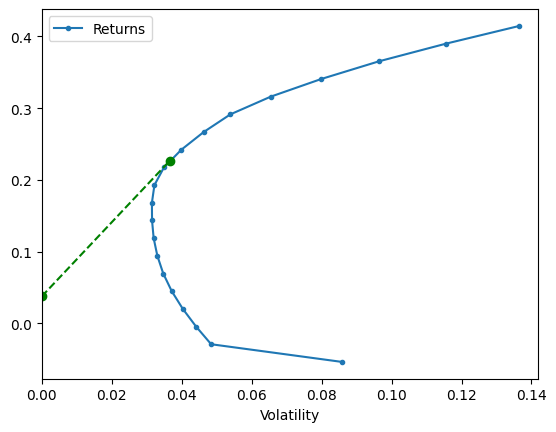

In [20]:
# plot the efficient frontier, for all 30 assets
ax = erk.plot_ef(n_points=20, er=er, cov=cov)
ax.set_xlim(left=0)
# risk-free rate default 0.0377 
rf = 0.0377
w_msr = erk.msr(riskfree_rate=rf, er=er, cov=cov) # weights of msr
r_msr = erk.portfolio_return(weights=w_msr, returns=er) # returns of msr
vol_msr = erk.portfolio_vol(weights=w_msr, covmat=cov) # vol of msr
# capital market line
cml_x = [0, vol_msr] 
cml_y = [rf, r_msr] 
ax.plot(cml_x, cml_y, color='green', marker="o", linestyle='dashed')

<Axes: xlabel='Volatility'>

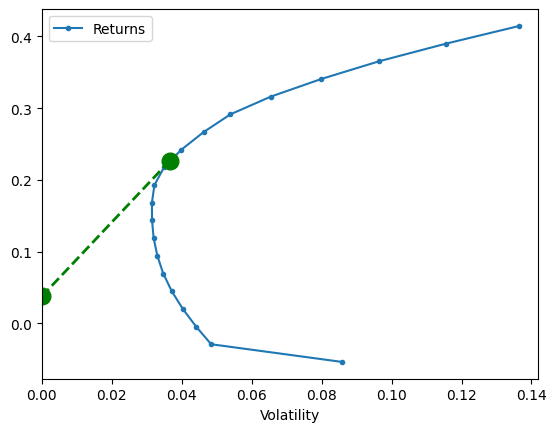

In [21]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.0377)

# Lack of robustness of Markowitz analysis

### Global Minimum Variance portfolio
* the only portfolio on the efficient frontier for which no expected return parameter is needed
* success of the global minimum variance portfolio in practice is due to the fact that, again, we are trying to minimize variance without any expected return targets, which are often noise
* the portfolio that is least sensitive to errors in parameter estimates, no expected return estimates, it is only sensitive to errors in risk parameter estimates

Pitfalls in implementation with the Markowitz Analysis
* parameter estimates

In [22]:
# two assets
l = ['Food', 'Steel']
erk.msr(riskfree_rate=0.0377, er=er[l], cov=cov.loc[l,l])

array([0.74074232, 0.25925768])

allocations of 74% and 26%, but this depends on expected returns

In [23]:
# expected returns used in calculation
er[l]

Food     0.116799
Steel    0.115809
dtype: float64

estimated returns, imperfect, note: these are actual returns, but in practice these would be estimates

In [28]:
# assuming reasonable guess feed as expected returns
guess = np.array([0.11, 0.12])
erk.msr(riskfree_rate=0.0377, er=guess, cov=cov.loc[l,l])

array([0.71145588, 0.28854412])

allocations 74 -> 71% and 26 -> 29%

In [31]:
# assuming a less-than-reasonable guess feed as expected returns
guess = np.array([0.10, 0.13])
erk.msr(riskfree_rate=0.0377, er=guess, cov=cov.loc[l,l])

array([0.6523493, 0.3476507])

allocations 74 -> 65% and 26 -> 35%

In [32]:
# assuming a less-than-reasonable guess feed as expected returns
guess = np.array([0.13, 0.10])
erk.msr(riskfree_rate=0.0377, er=guess, cov=cov.loc[l,l])

array([0.8094859, 0.1905141])

allocations 74 -> 81 % and 26 -> 19%

<Axes: xlabel='Volatility'>

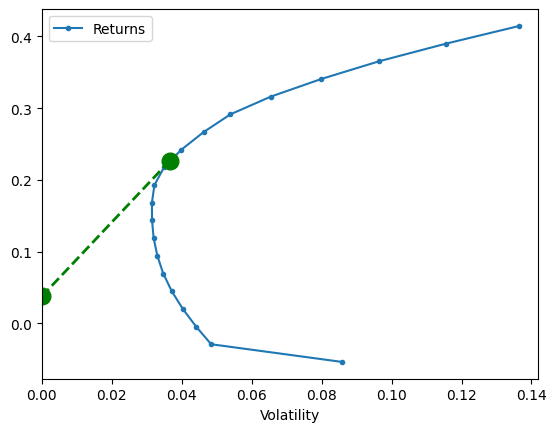

In [33]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.0377)

huge problem: error maximizing nature of Markowitz analysis
* a small change (due to inaccurate estimates) in estimated/expected returns causes a dramatic change in allocation weights
* the tangential portfolio the MSR, is very hard to achieve, you must have a very accurate estimated return
huge opportunity: GMV
* on the efficient frontier, just below the MSR, the apex or nose, is the GMV, Global Minimum Variance portfolio
* GMV is of all possible portfolios, the portfolio with minimum volatility
naive but accurate: EW
* the initial guess in MSR calculation `np.repeat(1/n, n)`, is the EW, Equally-Weighted portfolio
* EW is not subject to any estimation error, and will likely have a higher risk-adjusted performance vs MSR
* also known as 'naive diversification portfolio'

<Axes: xlabel='Volatility'>

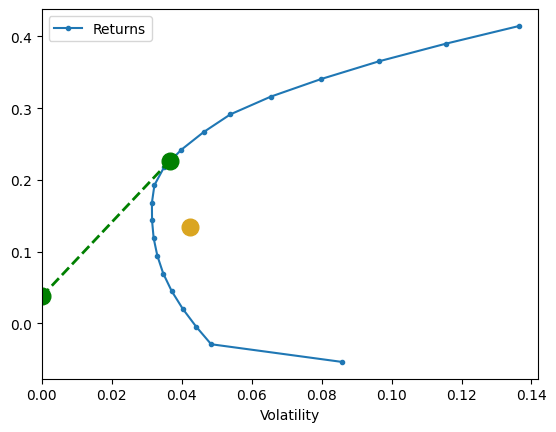

In [36]:
# show the EW portfolio
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.0377, show_ew=True)

In [37]:
n = 30
np.repeat(1/n, n)

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

the EW portfolio is inside the efficient frontier 

<Axes: xlabel='Volatility'>

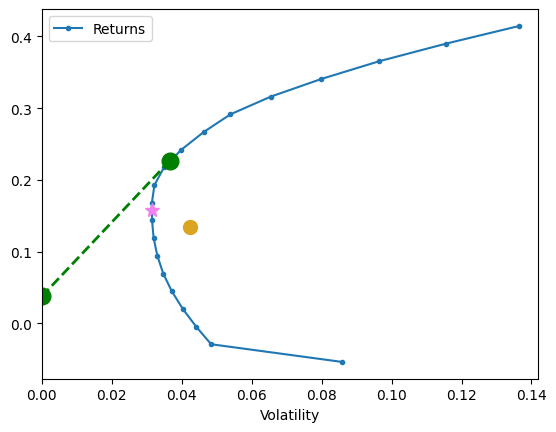

In [39]:
# show the GMV portfolio
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.0377, show_ew=True, show_gmv=True)

the GMV is at the nose, apex

both GMV and EW do not require expected returns

GMV is on the efficient frontier with higher returns and lower volatility than EW, GMV has lower returns and lower volatility than the ~unattainable MSR portfolio

GMV: you DO need to estimate the covariance matrix, which is an easier estimate compared to returns